## Project 2 - Natural Language Processing - Sarcasm Detection - Part-B
**Problem Statement**
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

**Dataset Description**
News Headlines dataset for Sarcasm Detection. The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embedding. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self- contained. This would help us in teasing apart the real sarcastic elements Content Each record consists of three attributes:
- `is_sarcastic`: 1 if the record is sarcastic otherwise 0
- `headline`: the headline of the news article
- `article_link`: link to the original news article. Useful in collecting supplementary data

**Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

### Import Packages

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/NLP/Sarcasm Detection/')

In [3]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# # Text preprocessing and stopwords
# from text_preprocess import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

# !rm -R log/

### Loading Dataset

In [4]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Is Sarcastic count: 13634 i.e. 48.0%
Isn't Sarcastic count: 14985 i.e. 52.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


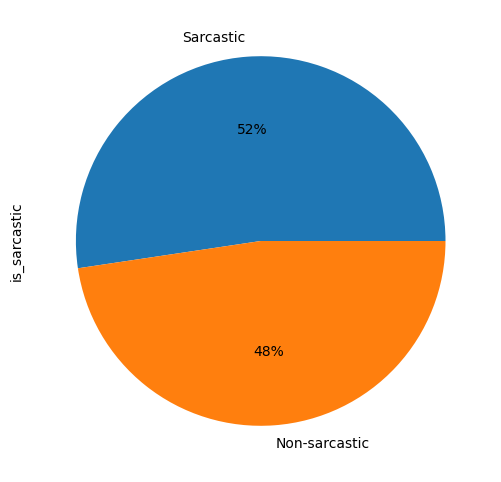

In [5]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [6]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]],
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,13634
Non-sarcastic,14985,1


In [7]:
# Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: mother's day ad shows moms from the perspective of toddlers
label: 0

Headline: netanyahu plays nice on iran, arabs in washington speech
label: 0

Headline: reinventing reality: an interview with the 'party girl' filmmakers in cannes
label: 0

Headline: despondent jeff bezos realizes he'll have to work for 9 seconds to earn back money he lost in divorce
label: 1

Headline: philando castile's high school classmates award first scholarship in his honor
label: 0



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: new evidence suggests humans may have been dipping crunchy things into gooey things earlier than previously thought
label: 1

Headline: 'i'm afraid you won't be coming to our new headquarters,' declares alexa as amazon execs find themselves locked in seattle office
label: 1

Headline: south korean president shakes hands with north korean leaders during winter olympics opening ceremony
label: 0

Headline: from birth control to culturally competent care, affordable care act breaks down health care barriers
label: 0

Headline: critiquing democratic responses to the 2016 election- part i, the problem lies with working class voters themselves
label: 0

------------------------------------------------------------
Distributon of label where the length of headline is > 100
-

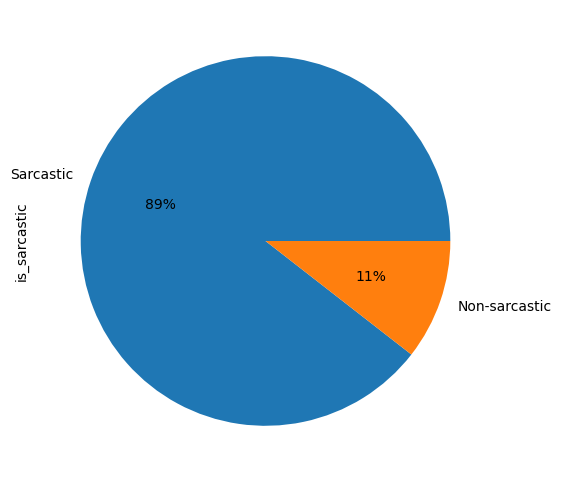

In [8]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

#### **Observation**
* 52% of the data have sarcastic labels whereas 48% don't.
* Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
* Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
* There are digits in the headlines for e.g. `3 things i needed to hear when i weighed 300 pounds` where removing the digits wouldn't help.
* 89% of data where length of sentence (headlines) > 100 are sarcastic headlines.

### Drop `article_link` from dataset.

In [9]:
print('Dropping `article_link` from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)

Dropping `article_link` from the data
------------------------------------------------------------


### Data Preprocessing
Few of the data pre-processing steps taken before applying model on the data

* Converting to lower case, avoid any capital cases
* Converting apostrophe to the standard lexicons
* Removing punctuations
* Lemmatization

In [10]:
# Import packages
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

nltk.download('averaged_perceptron_tagger')

# Reference: https://github.com/sharmapratik88/AppliedNLPWorkshop/blob/master/HelperCodes/text_prep_config.py
appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot",
         "can't've": "cannot have", "'cause": "because",
         "could've": "could have", "couldn't": "could not",
         "couldn't've": "could not have", "didn't": "did not",
         "doesn't": "does not", "don't": "do not", "hadn't": "had not",
         "hadn't've": "had not have", "hasn't": "has not",
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
         "he'll": "he will", "he'll've": "he will have",
         "he's": "he is", "how'd": "how did",
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
         "I'll've": "I will have", "I'm": "I am", "I've": "I have",
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
         "it'll": "it will", "it'll've": "it will have", "it's": "it is",
         "let's": "let us", "ma'am": "madam", "mayn't": "may not",
         "might've": "might have", "mightn't": "might not",
         "mightn't've": "might not have", "must've": "must have",
         "mustn't": "must not", "mustn't've": "must not have",
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not",
         "oughtn't've": "ought not have", "shan't": "shall not",
         "sha'n't": "shall not", "shan't've": "shall not have",
         "she'd": "she would", "she'd've": "she would have",
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have",
         "shouldn't": "should not", "shouldn't've": "should not have",
         "so've": "so have", "so's": "so is",
         "that'd": "that had", "that'd've": "that would have",
         "that's": "that that is", "there'd": "there would",
         "there'd've": "there would have", "there's": "there is",
         "they'd": "they would", "they'd've": "they would have",
         "they'll": "they will", "they'll've": "they will have",
         "they're": "they are", "they've": "they have",
         "to've": "to have", "wasn't": "was not", "we'd": "we would",
         "we'd've": "we would have", "we'll": "we will",
         "we'll've": "we will have", "we're": "we are",
         "we've": "we have", "weren't": "were not",
         "what'll": "what will", "what'll've": "what will have",
         "what're": "what are", "what's": "what is",
         "what've": "what have", "when's": "when is",
         "when've": "when have", "where'd": "where did",
         "where's": "where is", "where've": "where have",
         "who'll": "who will", "who'll've": "who will have",
         "who's": "who is", "who've": "who have",
         "why's": "why is", "why've": "why have", "will've": "will have",
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not",
         "wouldn't've": "would not have", "y'all": "you all",
         "y'all'd": "you all would", "y'all'd've": "you all would have",
         "y'all're": "you all are", "y'all've": "you all have",
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have",
         "you're": "you are", "you've": "you have"}

# Helper function to replace appos
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Helper function to remove punctuations
# Reference: https://www.programiz.com/python-programming/methods/string/translate
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' #string.punctuation
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Helper function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

# Helper function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])

# Helper function for wordcloud
# Reference: https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40,
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150,
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))

    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black',
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

# Second helper function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [11]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
# data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_stopwords(x))
print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
------------------------------------------------------------


### Get the Length of each line and find the maximum length
As different lines are of different length. We need to pad the our sequences using the max length.

In [12]:
print('--'*40); print('Get the length of each line, find the maximum length and print the maximum length line');
print('Length of line ranges from 7 to 241.'); print('--'*40)
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the maximum length and print the maximum length line
Length of line ranges from 7 to 241.
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 893
Line with maximum length: hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book unti

In [13]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words');
print('Number of words ranges from 2 to 39.'); print('--'*40)
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the number of words, find the maximum number of words and print the maximum number of words
Number of words ranges from 2 to 39.
--------------------------------------------------------------------------------
Minimum number of words: 2
Maximum number of words: 151
Line with maximum number of words: hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down 

Word Cloud of Sarcastic and Non-sarcastic Headlines


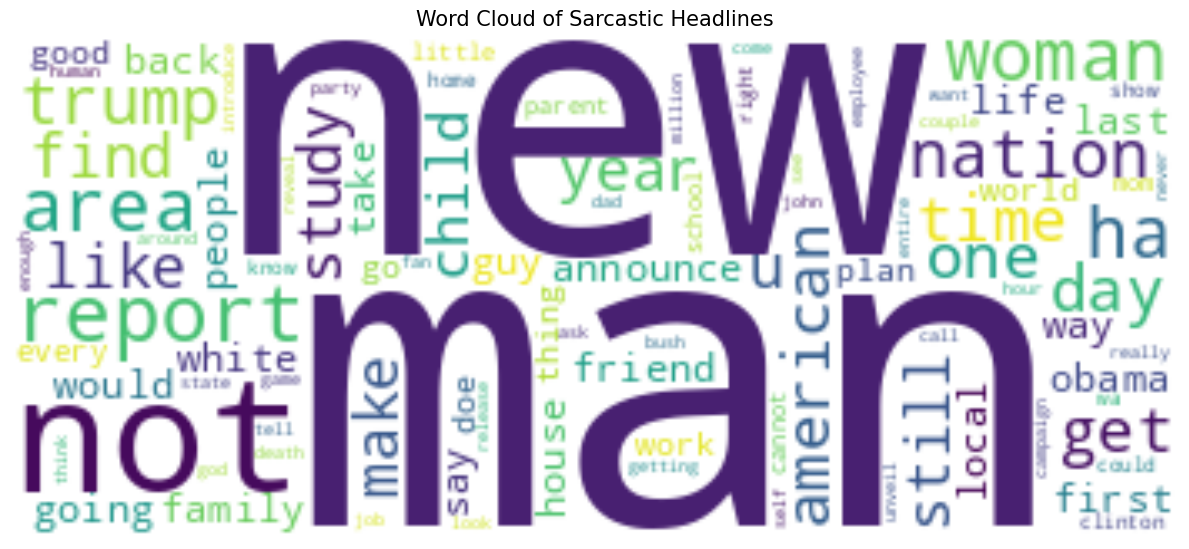

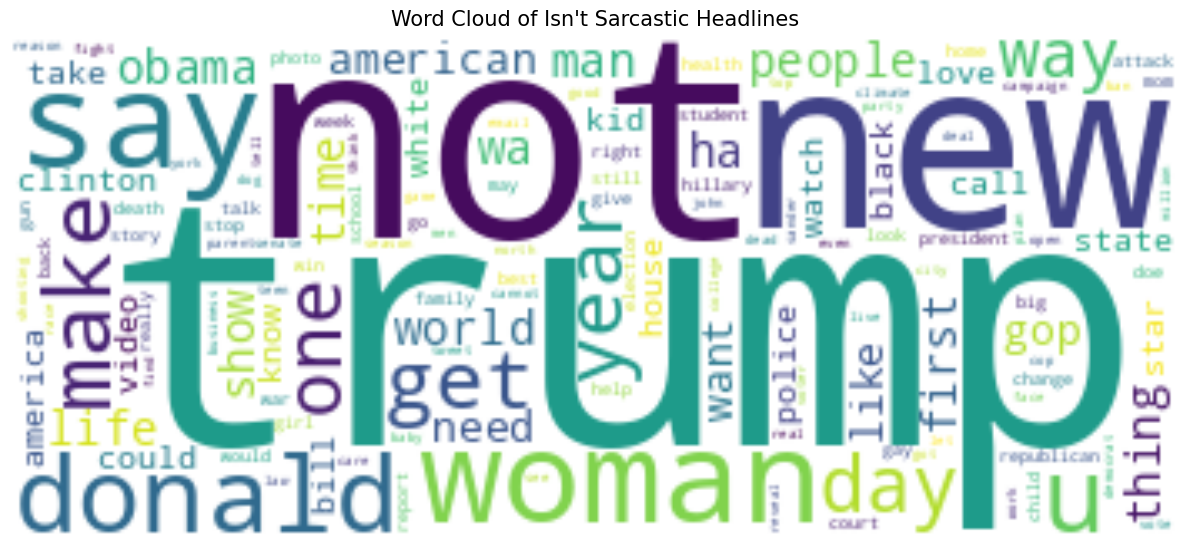

In [14]:
print('Word Cloud of Sarcastic and Non-sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Isn\'t Sarcastic Headlines')

### Modelling

In [15]:
print('--'*30); print('Five point summary for number of words')
display(data['nb_words'].describe().round(0).astype(int));

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));print('--'*30)

------------------------------------------------------------
Five point summary for number of words


count    28619
mean        10
std          3
min          2
25%          8
50%         10
75%         12
max        151
Name: nb_words, dtype: int64

99% quantilie: 19.0
------------------------------------------------------------


#### Set Different Parameters for the model

In [16]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

### Applying Keras Tokenizer to Get indices for words

In [17]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

### Define X and y for your model & create Features and Labels

In [18]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 28619
Number of Labels: 28619

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  326 2958 5781 2067    2  692 1093]

Label of the first headline: 1


### Get the Vocabulary size

In [19]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 26042


### Word Embedding

#### Get Glove Word Embeddings

In [20]:
glove_file = 'glove.6B.zip'

In [21]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

#### Get word embeddings using embedding file

In [24]:
EMBEDDING_FILE = 'glove.6B/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

#### Create a weight matrix

In [25]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

### Create and Compile Model
* Split the data into train, valid and test set so that it's easy to compare and evaluate
* Use Sequential model instance
* Add Embedding layer
* Bidirectional(LSTM) layer
* GlobalMaxPool1D layer
* Dense, dropout layers
* Add a final dense layer with sigmoid activation for binary classification

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 22895
Number of columns in training dataset: 151
Number of unique words in training dataset: 9975
------------------------------------------------------------ 
Number of rows in test dataset: 5724
Number of columns in test dataset: 151
Number of unique words in test dataset: 7640


In [27]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 151, 200)          2000200   
                                                                 
 bidirectional (Bidirectiona  (None, 151, 256)         336896    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

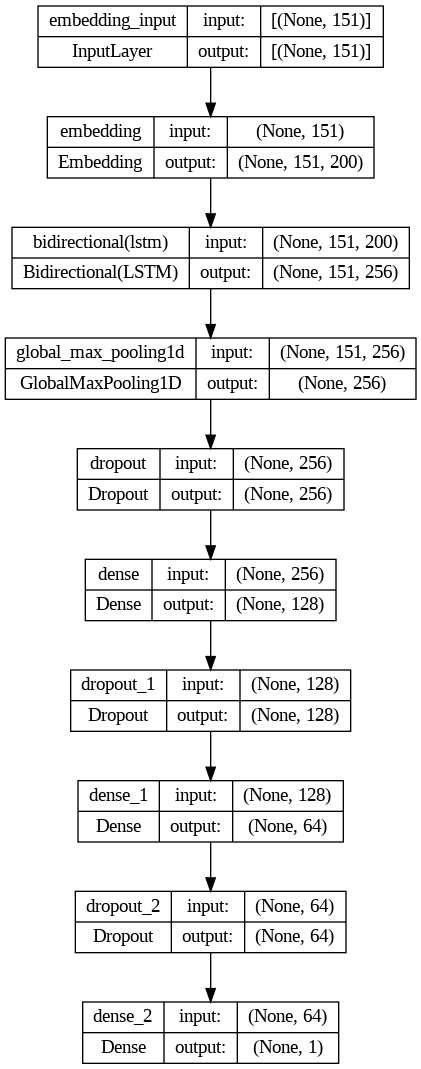

In [28]:
tf.keras.utils.plot_model(model, show_shapes = True)

### Fitting model
* Setting batch_size = 100 and epoch =

In [29]:
batch_size = 100
epochs = 6

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6

Epoch 1: val_loss improved from inf to 0.47070, saving model to sarcasm_detector.h5
184/184 - 18s - loss: 0.6007 - accuracy: 0.6576 - val_loss: 0.4707 - val_accuracy: 0.7847 - lr: 0.0010 - 18s/epoch - 97ms/step
Epoch 2/6

Epoch 2: val_loss improved from 0.47070 to 0.40777, saving model to sarcasm_detector.h5
184/184 - 7s - loss: 0.4506 - accuracy: 0.7966 - val_loss: 0.4078 - val_accuracy: 0.8218 - lr: 0.0010 - 7s/epoch - 37ms/step
Epoch 3/6

Epoch 3: val_loss improved from 0.40777 to 0.37688, saving model to sarcasm_detector.h5
184/184 - 7s - loss: 0.3894 - accuracy: 0.8299 - val_loss: 0.3769 - val_accuracy: 0.8401 - lr: 0.0010 - 7s/epoch - 36ms/step
Epoch 4/6

Epoch 4: val_loss improved from 0.37688 to 0.34624, saving model to sarcasm_detector.h5
184/184 - 7s - loss: 0.3459 - accuracy: 0.8534 - val_loss: 0.3462 - val_accuracy: 0.8478 - lr: 0.0010 - 7s/epoch - 38ms/step
Epoch 5/6

Epoch 5: val_loss improved from 0.34624 to 0.33909, saving model to sarcasm_detector.h5
184/184

In [30]:
%load_ext tensorboard
%tensorboard --logdir log/

<IPython.core.display.Javascript object>

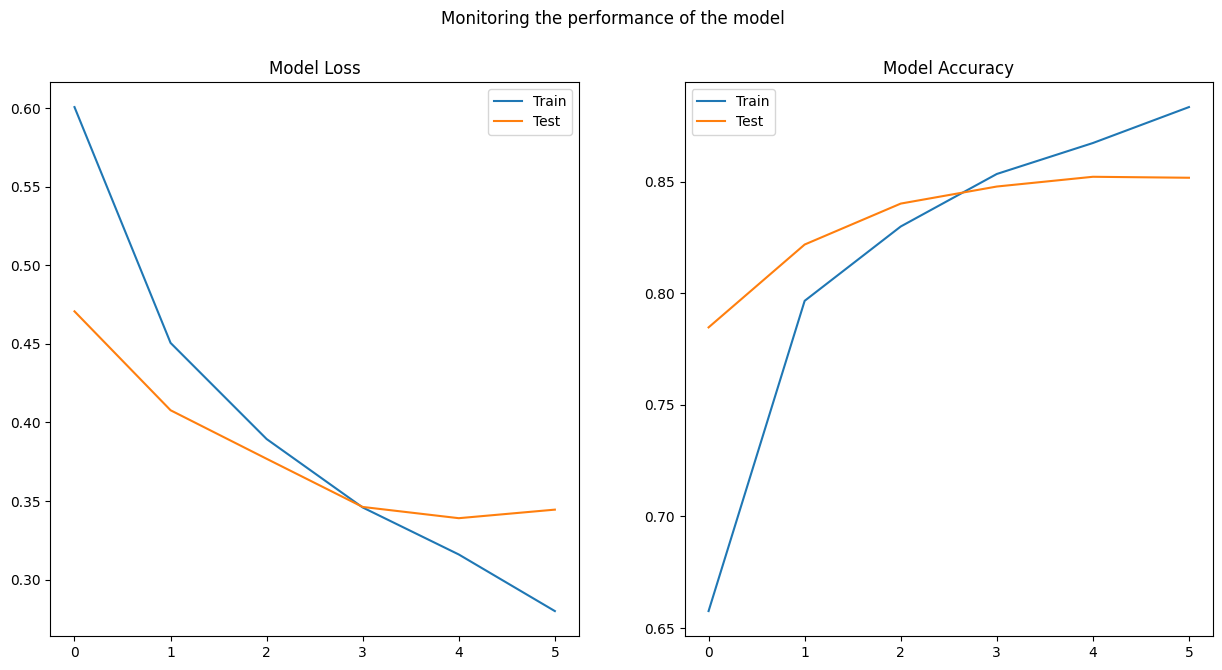

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 85.0


In [33]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

179/179 [==============================] - 2s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      3362
           1       0.77      0.89      0.83      2362

    accuracy                           0.85      5724
   macro avg       0.84      0.85      0.84      5724
weighted avg       0.86      0.85      0.85      5724



------------------------------------------------------------
Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2739,256
Sarcastic,623,2106


------------------------------------------------------------


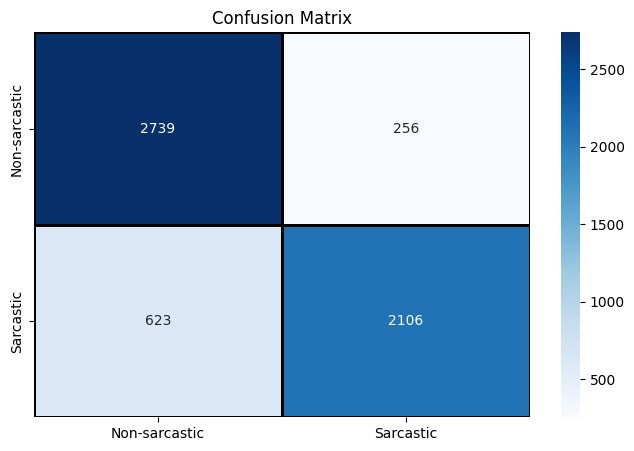

In [34]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True,
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'],
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

In [35]:
print('Evaluate model on sample sarcastic lines'); print('--'*30)
statements = ['Are you always so stupid or is today a special ocassion?', #Sarcasm
              'I feel so miserable without you, it\'s almost like having you here.', #Sarcasm
              'If you find me offensive. Then I suggest you quit finding me.', #Sarcasm
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcasm
              'Amphibious pitcher makes debut', #Sarcasm
              'It\'s okay if you don\'t like me. Not everyone has good taste.' #Sarcasm
              ]

for statement in statements:
  statement = statement.lower()
  statement = replace_words(statement)
  statement = remove_punctuation(statement)
  statement = lem(statement)
  statement = re.sub(' +', ' ', statement)

  headline = tokenizer.texts_to_sequences(statement)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline) > 0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'`{statement}` is a Non-sarcastic statement.')
  elif (np.argmax(sentiment) == 1):
      print(f'`{statement}` is a Sarcastic statement.')

Evaluate model on sample sarcastic lines
------------------------------------------------------------
1/1 [==============================] - 0s 22ms/step
`amphibious pitcher make debut` is a Sarcastic statement.
2/2 [==============================] - 0s 10ms/step


### Conclusion
* We used data pre-processing techniques to clean headlines, such as:
  * Converting to lower case
  * Converting to standard lexicons such as it's to it is
  * Remove punctuations
  * Lemmatize
  * Remove multiple spaces
* Some of the observation:
  * 52% of the data have sarcastic labels whereas 48% don't.
  * Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
  * Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
  * There are digits in the headlines for e.g. *3 things i needed to hear when i weighed 300 pounds* where removing the digits wouldn't help.
  * 89% of data where length of sentence (headlines) > 100 are sarcastic headlines.
* Used Glove embedding layer with Bidirectional LSTM layer. Model architecture was also plotted. Also saw how we can use tensorboard to visualize the metrics such as loss and accuracy.
* Created a separate training and test sets; while fitting the model kept aside a 0.2 for validation;
* Model achieved 85% accuracy on the test set; classification report and confusion matrix were also printed.
* Model was also evaluated on some sample sarcastic statements and did well in identifying all them as sarcasm.